## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

<img src="https://i.imgur.com/Sxm12BY.png" width="900">



## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

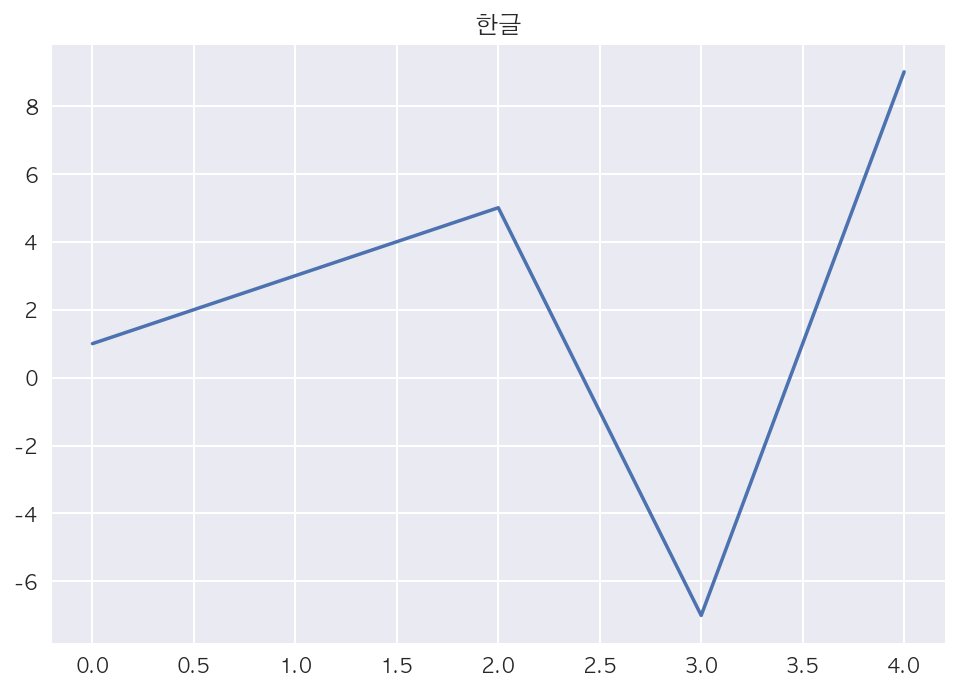

In [3]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

## 데이터 로드

In [4]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [5]:
# 토픽을 불러옵니다.
topic = pd.read_csv("data/klue/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 문자 전처리
### 전처리 함수로 전처리 하기

* [정규 표현식 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%A0%95%EA%B7%9C_%ED%91%9C%ED%98%84%EC%8B%9D)


In [1]:
# 정규표현식 불러오기
import re

In [2]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [8]:
# 정규표현식 확인
text = "전처리가 잘~~~되는지 확인 합니다. 공    백도 확인하고 숫자0-9도 확인 합니다. EnglisH는 모두 소문자로 만듭니다."
preprocessing(text)

'전처리가 잘 되는지 확인 합니다 공 백도 확인하고 숫자 도 확인 합니다 english는 모두 소문자로 만듭니다 '

In [9]:
# map을 통해 전처리 일괄 적용
train["title"] = train["title"].map(preprocessing)
test["title"] = test["title"].map(preprocessing)

### 불용어 제거

In [10]:
# 불용어 제거
# 불용어를 추가하여 어휘를 추가로 제거할 수 있습니다.
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [11]:
# map을 통해 불용어 일괄 제거
X_train_text = train["title"].map(remove_stopwords)
X_test_text = test["title"].map(remove_stopwords)

## 학습 예측 데이터셋

In [12]:
# 학습, 예측 데이터셋 정의
# 학습세트(예: 시험의 기출문제)
# 예측세트(예: 실전 시험문제)
X_train_text = train["title"]
X_test_text = test["title"]

In [13]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = "topic_idx"

In [14]:
# 학습 세트의 정답
y_train = train[label_name]
y_train.shape

(45654,)

In [15]:
y_train.head()

0    4
1    4
2    4
3    4
4    4
Name: topic_idx, dtype: int64

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### CountVectorizer
* CountVectorizer 는 사이킷런에서 제공하는 bag of words 를 만들 수 있는 방법입니다.
* 텍스트 문서 모음을 토큰 수의 행렬로 변환합니다.

* 단어들의 카운트(출현 빈도)로 여러 문서들을 벡터화
* 문서목록에서 각 문서의 feature(문장의 특징) 노출수를 가중치로 설정한 BOW 벡터를 생성
* 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
* max_df, min_df 인수를 사용하여 문서에서 토큰이 나타난 횟수를 기준으로 단어장을 구성할 수도 있음 
* 토큰의 빈도가 max_df로 지정한 값을 초과 하거나 min_df로 지정한 값보다 작은 경우에는 무시하며 인자 값은 정수인 경우 횟수, 부동소수점인 경우 비율을 의미
* API documentation:https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### 사용법
1. 문서를 토큰 리스트로 변환한다.
2. 각 문서에서 토큰의 출현 빈도를 센다.
3. 각 문서를 BOW 인코딩 벡터로 변환한다.
4. 매개 변수
    * analyzer : 단어, 문자 단위의 벡터화 방법 정의
    * ngram_range : BOW 단위 수 (1, 3) 이라면 1개~3개까지 토큰을 묶어서 벡터화
    * max_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 높은 용어(말뭉치 관련 불용어)는 제외 (기본값=1.0)
        * max_df = 0.90 : 문서의 90% 이상에 나타나는 단어 제외
        * max_df = 10 : 10개 이상의 문서에 나타나는 단어 제외
    * min_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 낮은 용어는 제외합니다. 컷오프라고도 합니다.(기본값=1.0)
        * min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 제외
        * min_df = 10 : 문서에 10개 미만으로 나타나는 단어 제외
    * stop_words : 불용어 정의

In [16]:
# CountVectorizer 로 벡터화 합니다.
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(ngram_range=(1,2),
                             min_df=3, 
                             max_df=0.95)
cvect.fit(X_train_text)

CountVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 2))

In [17]:
# 변환
X_train = cvect.transform(X_train_text)
X_test = cvect.transform(X_test_text)

X_train.shape, X_test.shape

((45654, 22362), (9131, 22362))

In [18]:
# 단어 사전
feature_names = cvect.get_feature_names_out()
print(len(feature_names))
feature_names[:10]

22362


array(['abs', 'ac', 'acl', 'afc', 'afc 챔스리그', 'afc 챔피언십', 'afc 회장', 'ag',
       'ag 우승', 'ai'], dtype=object)

In [19]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더합니다. axis=0 으로 합니다. 
dist = np.sum(X_train, axis=0)

vocab_count = pd.DataFrame(dist, columns=feature_names)
vocab_count

,abs,ac,acl,afc,afc 챔스리그,afc 챔피언십,afc 회장,ag,ag 우승,ai,...,힘들,힘들다,힘들면,힘들어,힘으로,힘은,힘이,힘입어,힘찬,힙합
0,3,3,10,27,9,5,3,39,4,254,...,3,3,3,4,9,6,3,4,5,3


In [20]:
vocab_count.T[0].sort_values(ascending=False).head()

대통령    1363
억원      819
게시판     734
출시      734
신간      671
Name: 0, dtype: int64

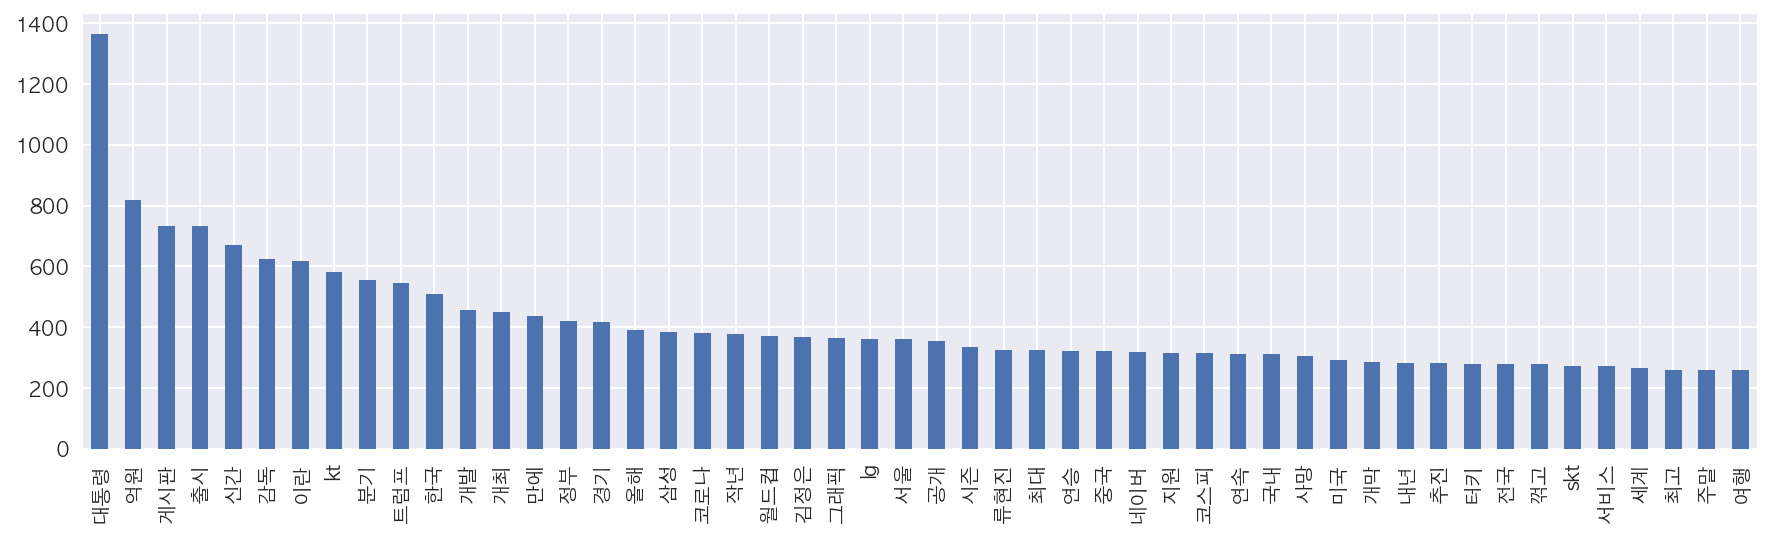

In [21]:
# 위에서 구한 빈도수를 그래프로 그립니다.
vocab_count.T[0].sort_values(ascending=False).head(50).plot.bar(figsize=(15, 4))

## 모델 불러오기

In [22]:
# DecisionTreeClassifier 를 불러옵니다.
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42, max_depth=5)
model

DecisionTreeClassifier(max_depth=5, random_state=42)

## 학습

In [23]:
# fit 으로 학습시킵니다.
%time model.fit(X_train, y_train)

CPU times: user 52.5 ms, sys: 1.99 ms, total: 54.5 ms
Wall time: 53.3 ms


DecisionTreeClassifier(max_depth=5, random_state=42)

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

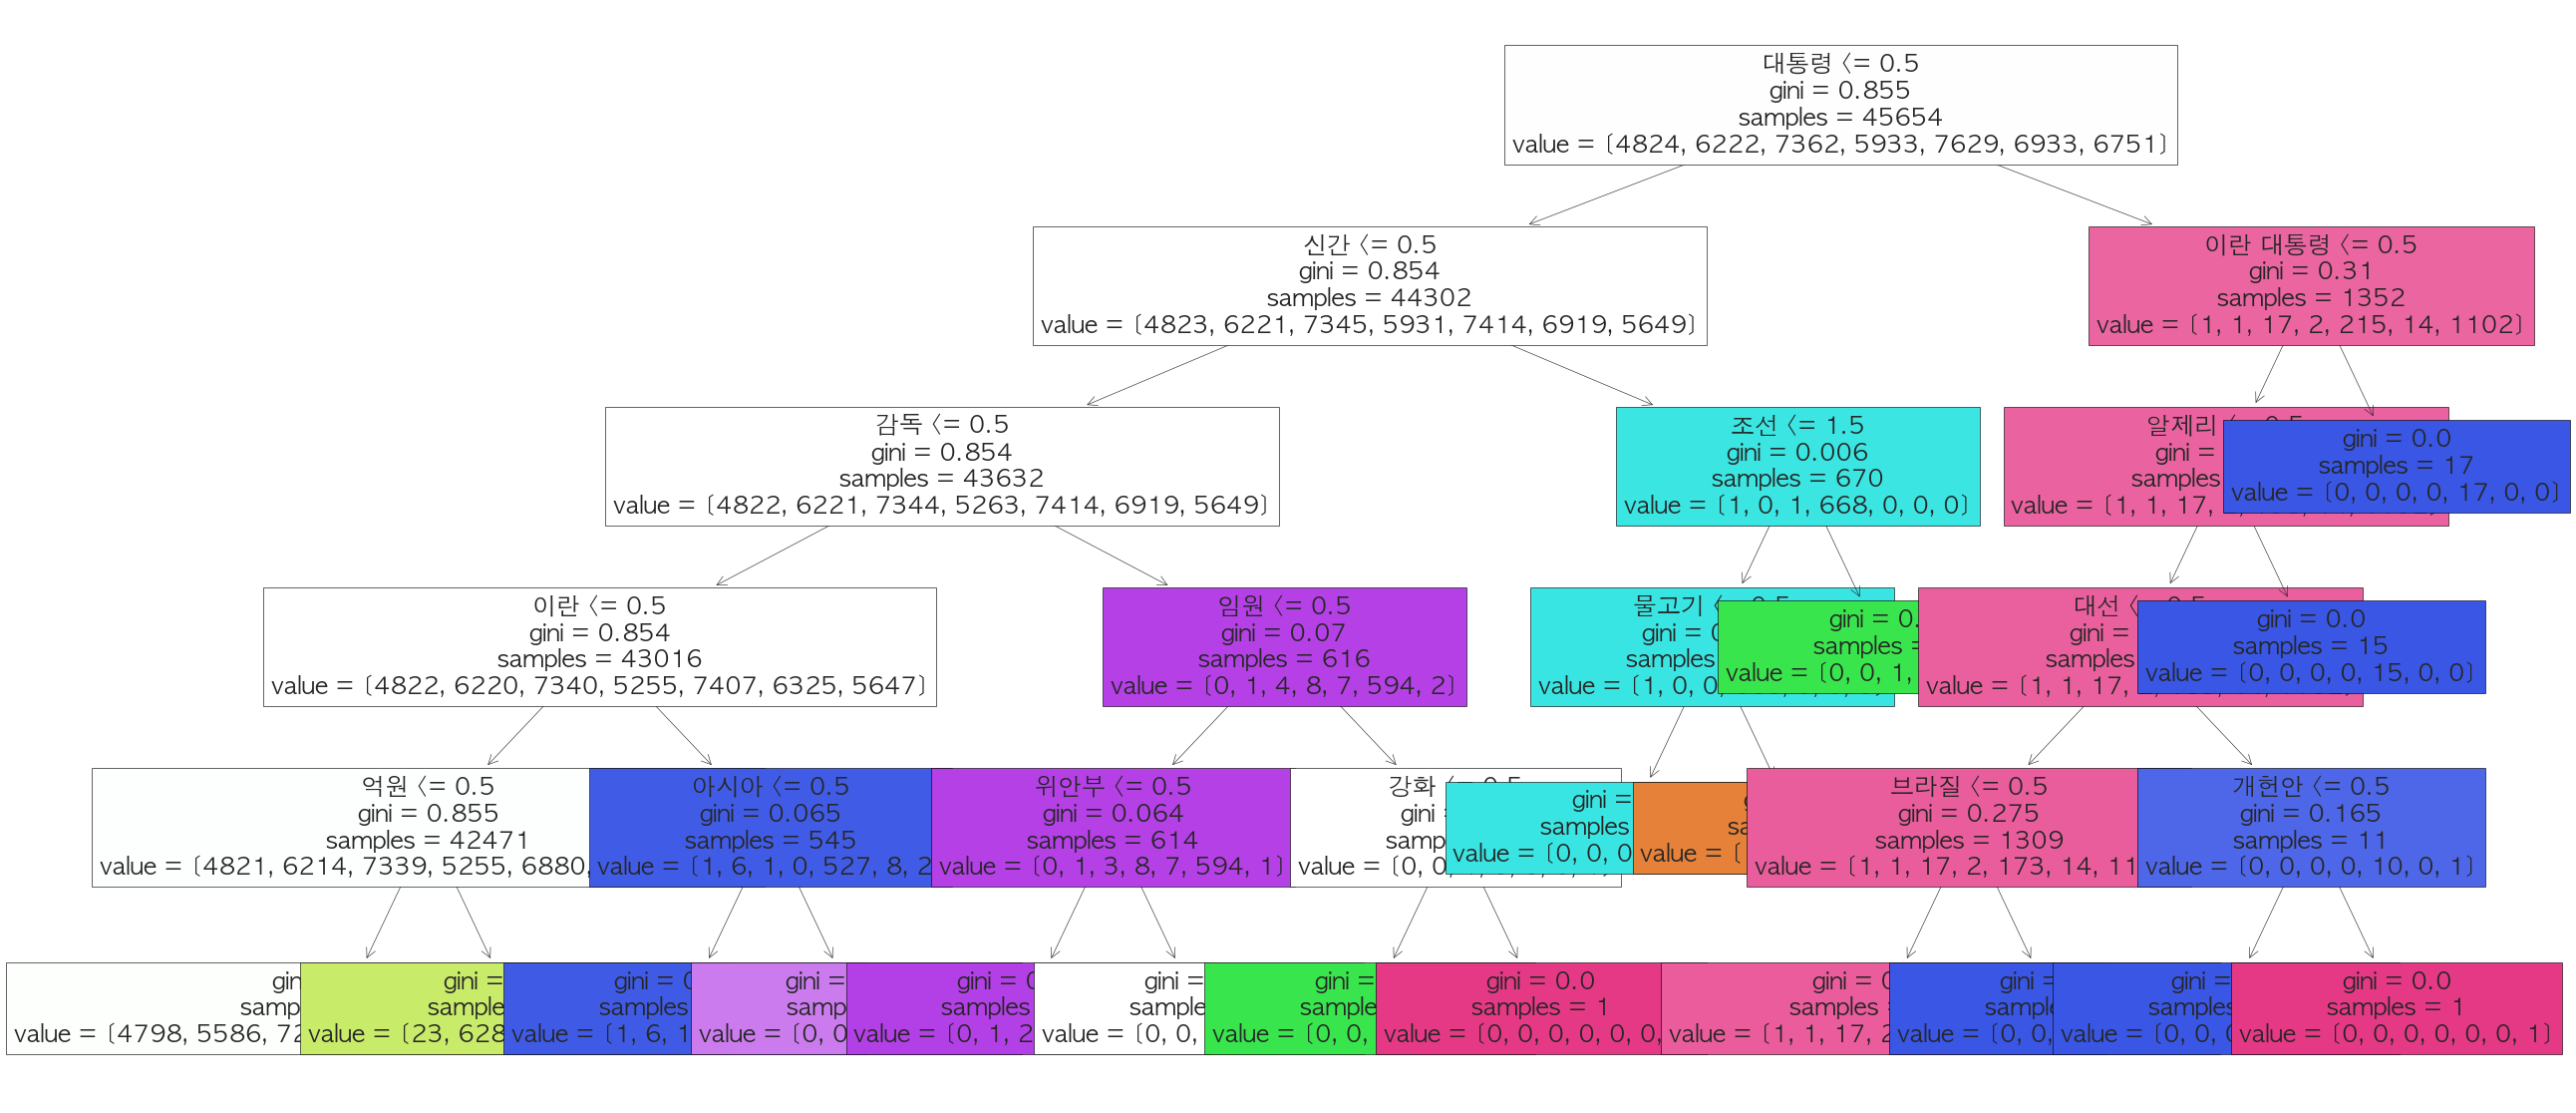

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, 
          feature_names=feature_names, 
          max_depth=5, fontsize=12, filled=True)
plt.show()

### 피처 중요도

In [25]:
# 피처 중요도가 높은 순으로 정렬해서 상위 10개만 봅니다.
fim = pd.Series(model.feature_importances_)
fim.index=feature_names
fim_largest = fim.sort_values().nlargest(10)
fim_largest

대통령       0.276488
신간        0.220734
감독        0.176737
이란        0.151784
억원        0.142177
이란 대통령    0.008790
알제리       0.007943
대선        0.004736
브라질       0.004376
아시아       0.001582
dtype: float64

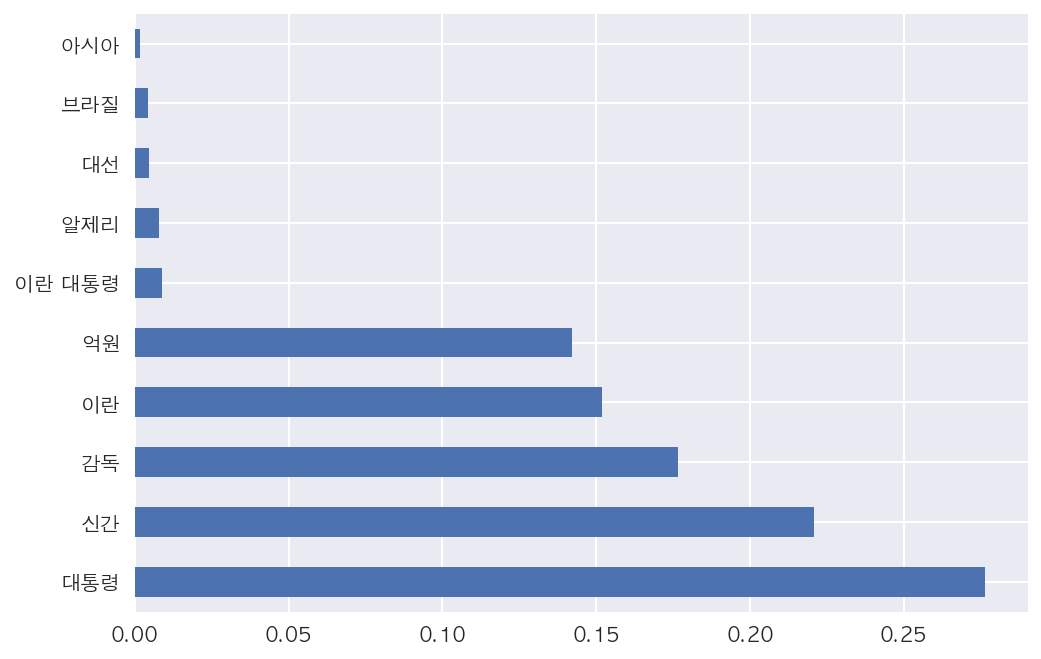

In [26]:
# 피처 중요도를 막대그래프로 시각화 합니다.
fim_largest.plot.barh()

### 예측

In [27]:
# predict로 예측합니다. 
y_predict = model.predict(X_test)
y_predict[:5]

array([2, 2, 2, 2, 2])

## 제출 파일 불러오기
* 답안지에 답을 옮겨 적고 제출하는 과정과 유사합니다.

In [28]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [29]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict.astype(int)
submit.head()

,index,topic_idx
0,45654,2
1,45655,2
2,45656,2
3,45657,2
4,45658,2


## 제출을 위해 파일 저장

In [30]:
# 제출을 위해 파일 저장하기
submit.to_csv("submission_dt.csv", index=False)

In [31]:
# 잘 저장되었는지 확인하기
pd.read_csv("submission_dt.csv")

,index,topic_idx
0,45654,2
1,45655,2
2,45656,2
3,45657,2
4,45658,2
...,...,...
9126,54780,2
9127,54781,2
9128,54782,2
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경